# Roller Coaster Classification Part 2

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('roller_coasters.csv')

df = df[df["material_type"].str.lower() != "na"]
df = df.dropna(subset=["material_type"])

# Features and target
X = df.drop(columns=["material_type"])
y = df["material_type"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# numeric and categorical feature lists
numeric_features = ["speed", "height", "length", "num_inversions"]
categorical_features = [col for col in X.columns if col not in numeric_features]

# build transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# fit on training, transform both train/test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# make sure Keras sees float32
X_train_prep = X_train_prep.astype("float32")
X_test_prep = X_test_prep.astype("float32")

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    keras.Input(shape=(X_train_prep.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")  # 3 classes
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# convert sparse matrices to dense numpy arrays
X_train_prep = X_train_prep.toarray()
X_test_prep = X_test_prep.toarray()

history = model.fit(
    X_train_prep, y_train_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

2025-08-19 16:32:33.116805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0176 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0069 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0095 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0129 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0079 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0079 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0113 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0097 - loss: nan - val_accuracy: 0.0083 - val_loss: nan
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Accuracy: 0.0088

Classification Report:
              precision    recall  f1-score   support

      Hybrid       0.01      1.00      0.02         4
       Steel       0.00      0.00      0.00       412
      Wooden       0.00      0.00      0.00        38

    accuracy                           0.01       454
   macro avg       0.00      0.33      0.01       454
weighted avg       0.00      0.01      0.00       454



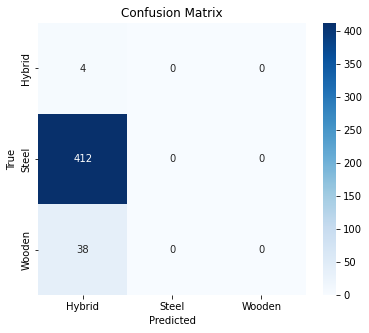

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred_probs = model.predict(X_test_prep)
y_pred = np.argmax(y_pred_probs, axis=1)   # take highest prob as class

# If y_test_enc is one-hot, convert back to integer labels
if y_test_enc.ndim > 1 and y_test_enc.shape[1] > 1:
    y_true = np.argmax(y_test_enc, axis=1)
else:
    y_true = y_test_enc  

# Accuracy
test_loss, test_acc = model.evaluate(X_test_prep, y_test_enc, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report with zero_division=0 to suppress warnings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

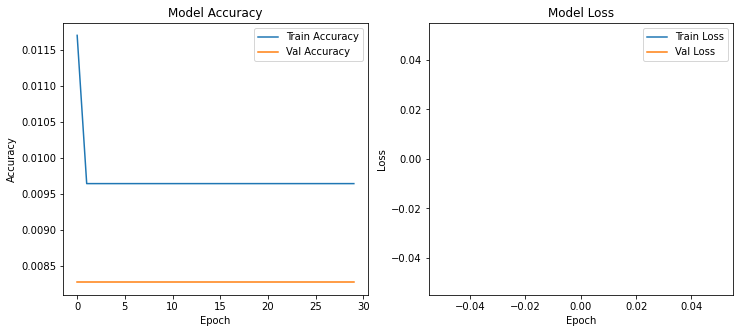

In [5]:
# Plot training curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()